# Counting blobs statistics for the NN accuracy

In [4]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib         as mpl

from scipy import stats
from time import time
from mpl_toolkits.mplot3d import Axes3D

from invisible_cities.io import mcinfo_io as mio
import invisible_cities.io.dst_io as dio
from invisible_cities.io   .dst_io  import load_dst

from next_sparseconvnet.data_io_scripts.plotting_utils import plot_projections, plot_3d_vox, plot_3d_hits
from next_sparseconvnet.utils.data_loaders import read_event, read_events_info

from next_sparseconvnet.utils.blob_classification_utils import *

# Ejemplo de cálculo del DF de estadística que saldría de get_net_stats.py

In [5]:
original = '/lustre/ific.uv.es/ml/ific020/nexus_2021/valid_dataset_5mm.h5'
pred_0  = '/lustre/ific.uv.es/ml/ific020/nexus_2021/segmentation/tfm_train/jul07_5mm/prediction_valid_dataset.h5'
pred_1  = ''
pred_2  = ''
pred_3  = ''
pred_4  = ''

In [6]:
#np.linspace(0.025, 0.975, 39)

In [7]:
#np.linspace(np.sqrt(3), 3 * np.sqrt(3), 20)

In [8]:
thresholds = np.arange(0.05, 1, 0.05) 
distances = np.linspace(np.sqrt(3), 2 * np.sqrt(3), 10)
results_df = pd.DataFrame()

#for th in thresholds:
 #   for dis in distances:
  #      print(round(th, 4), round(dis, 4))
   #     new_df = segmentation_blob_classification(original, pred_0, th, nevents = 50, max_distance = dis)
    #    acc, tpr, tnr = success_rates(new_df['binclass'], new_df['pred_class'])
     #   results_df = results_df.append(pd.DataFrame([[th, dis, acc, tpr, tnr]], columns = ['blobclass_th', 'blobcount_dis', 'acc', 'tpr', 'tnr']))
        
        

# Uso de get_net_stats.py

Para poner en marcha el script de estadística, crea un archivo.config con estos datos:

Luego, no conseguí no sé por qué, hacer que fuera con un job, entonces lo que te recomiendo es usar screen

* Con el comando screen entras como en una nueva pantalla. 
* Usando Ctrl+a,Ctrl+d sales sin cerrarla. 
* Para volver a entrar tienes que hacer screen -r
* Puedes abrir varias screens desde la pantalla principal poniendo simplemente screen
* Si tienes varias, puedes hacer screen -ls para ver las que tienes, y te salen con un # identificativo cada una al ppio
* Para entrar en una de las que tienes abiertas basta con hacer screen -r #
* Para eliminar cualquiera lo más facil es entrar en ella y hacer exit

Entonces, una vez en tu screen deberías hacer:

python /path/to/get_net_stats.py /path/to/stats.config

Ten en cuenta que tardará como ~1min por cálculo (normalmente menos), así que echa cuentas y más o menos tardará num_th x num_dis mins 

# NN stats from get_net_stats.py files

In [37]:
fileout = '/lhome/ext/ific020/ific0201/marcos_scripts/statistics/stat_basic_num_4.h5' #'/lhome/ext/ific020/ific0201/NEXT_SPARSECONVNET/examples/results_prueba_marcos.h5'#'/lhome/ext/ific020/ific0201/NEXT_SPARSECONVNET/examples/results_test.h5'
fileout_full = '/lhome/ext/ific020/ific0201/NEXT_SPARSECONVNET/examples/results_test_full.h5'
fileout_full_fast = '/lhome/ext/ific020/ific0201/NEXT_SPARSECONVNET/examples/results_test_full_fast.h5'

In [38]:
with tb.open_file(fileout_full, 'a') as h5out:
    print(h5out)

/lhome/ext/ific020/ific0201/NEXT_SPARSECONVNET/examples/results_test_full.h5 (File) ''
Last modif.: 'Wed Jun 29 10:54:18 2022'
Object Tree: 
/ (RootGroup) ''
/NN_RESULTS (Group) ''
/NN_RESULTS/Statistics (Table(190,), shuffle, zlib(4)) ''



In [39]:
results_df = dio.load_dst(fileout, 'NN_RESULTS', 'Statistics')

In [40]:
results_df_full = dio.load_dst(fileout_full, 'NN_RESULTS', 'Statistics')

In [41]:
results_df_full_fast = dio.load_dst(fileout_full_fast, 'NN_RESULTS', 'Statistics')

In [42]:
results_df_full[results_df_full.acc == results_df_full.acc.max()]

,blobclass_th,blobcount_dis,acc,tpr,tnr
86,0.45,2.886751,0.934494,0.884603,0.954007


In [43]:
def plot_net_stats(df, figsize = (10, 7), fmt = '-', fmt_label = '{:.2f}'):
    plt.figure(figsize = figsize)
    for th in df.blobclass_th.unique():
        th_df = df[df.blobclass_th == th]
        plt.plot(th_df.blobcount_dis, th_df.acc, fmt, label = fmt_label.format(th))
    plt.legend()
    plt.xlabel('voxel distances for blob counting (mm)')
    plt.ylabel('accuracy')
    plt.title('voxel distances vs accuracy')
        
    plt.figure(figsize = figsize)
    for dis in df.blobcount_dis.unique():
        dis_df = df[df.blobcount_dis == dis]
        plt.plot(dis_df.blobclass_th, dis_df.acc, fmt, label = fmt_label.format(dis) + ' mm')
    plt.legend()
    plt.xlabel('score threshold for blob class')
    plt.ylabel('accuracy')
    plt.title('score threshold vs accuracy')
    
    plt.figure(figsize = figsize)
    for dis in df.blobcount_dis.unique():
        roc_df = df[df.blobcount_dis == dis]
        plt.plot(roc_df.tnr.values, roc_df.tpr.values, fmt, label = fmt_label.format(dis) + ' mm')
    plt.legend()
    plt.xlabel('background rejection')
    plt.ylabel('signal efficiency')

    plt.figure(figsize = figsize)
    for dis in df.blobcount_dis.unique():
        roc_df = df[df.blobcount_dis == dis]
        plt.plot(roc_df.blobclass_th.values, roc_df.tpr.values / np.sqrt(roc_df.tnr.values), fmt, label = fmt_label.format(dis) + ' mm')
    plt.xlabel('blob class threshold')
    plt.ylabel('fom')
    plt.show()
    

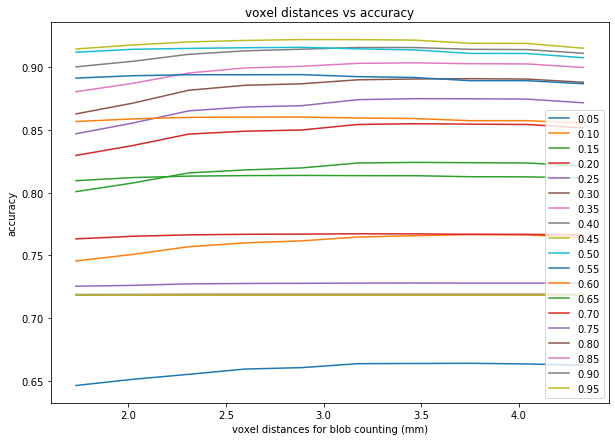

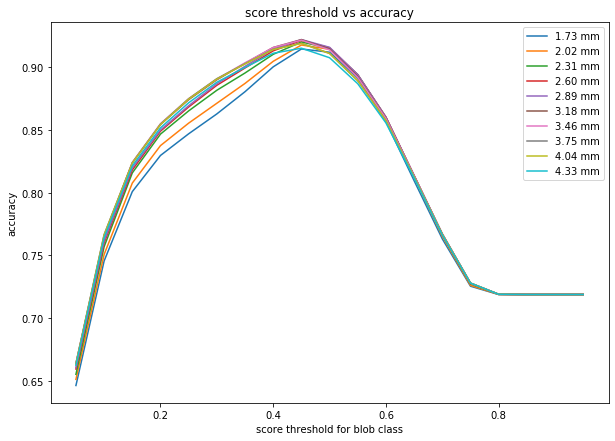

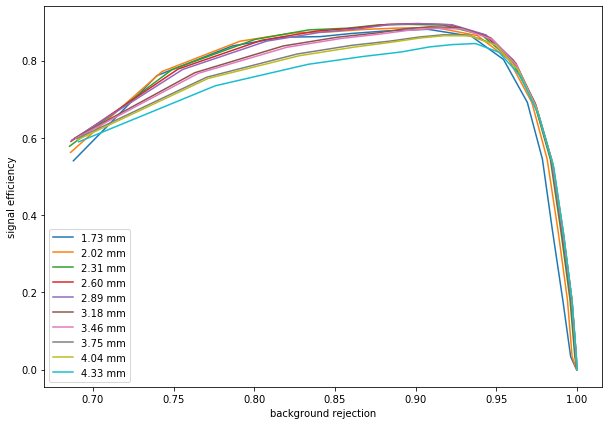

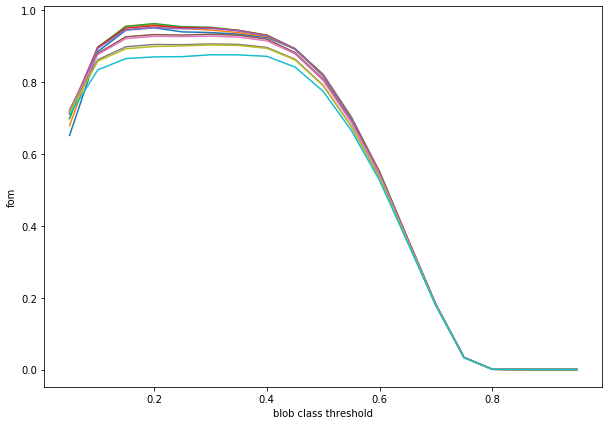

In [44]:
plot_net_stats(results_df)

 *** La bkg rejection no empieza en 0 pq todo lo que no sea blobcount == 2 se marca como bkg, entonces empieza en 0.75 que es aprox el % de eventos de fondo

In [45]:
ev_df = read_events_info(original, None)
1 - sum(ev_df.binclass)/len(ev_df)

0.71885845314824

## Heatmap de la exploración threshold-longitud

In [46]:
import seaborn as sns

In [47]:
def plot_net_stats_heatmap(df,
                           figsize = (10, 7),
                           cmap = None,
                           annot = True, 
                           annot_fmt = '.3f',
                           annot_ticks = '{:.2f}',
                           linewidth = 0.01,
                           cbar_label = 'accuracy', 
                           xlabel = '',
                           ylabel = '',
                           title = ''):
    matrix = []
    for th in df.blobclass_th.unique():
        matrix.append(df[df.blobclass_th == th].acc.values)
    
    fig, ax = plt.subplots(figsize = figsize)
    ax = sns.heatmap(matrix, 
                     annot = annot, 
                     fmt = annot_fmt, 
                     cmap = cmap,
                     xticklabels = [annot_ticks.format(i) for i in df.blobcount_dis.unique()],
                     yticklabels = [annot_ticks.format(i) for i in df.blobclass_th.unique()],
                     linewidth=linewidth, 
                     cbar_kws={'label': cbar_label})
    
    ax.set_xticks(np.arange(len(df.blobcount_dis.unique())) + 0.5)
    ax.set_yticks(np.arange(len(df.blobclass_th.unique())) + 0.5)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

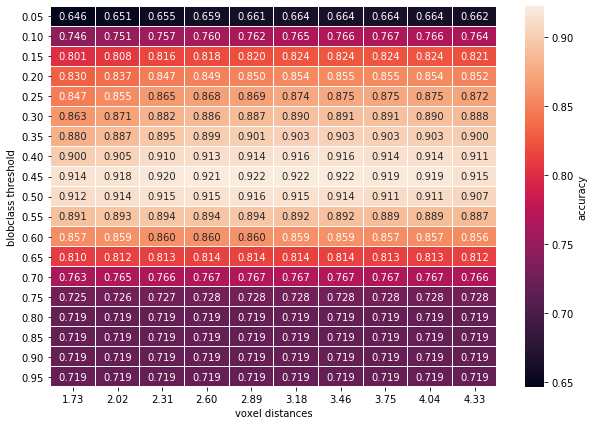

In [48]:
plot_net_stats_heatmap(results_df[:190], xlabel = 'voxel distances', ylabel = 'blobclass threshold')

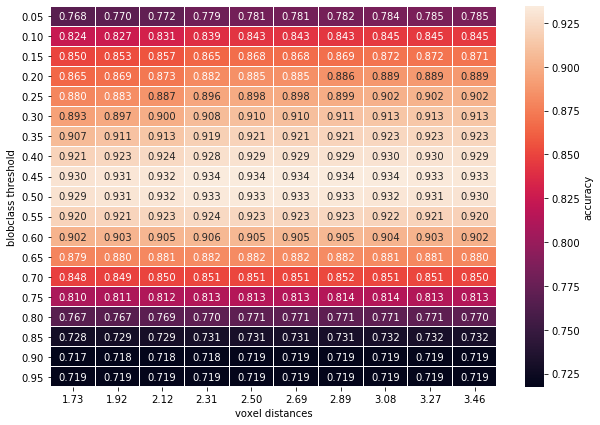

In [49]:
plot_net_stats_heatmap(results_df_full, xlabel = 'voxel distances', ylabel = 'blobclass threshold')

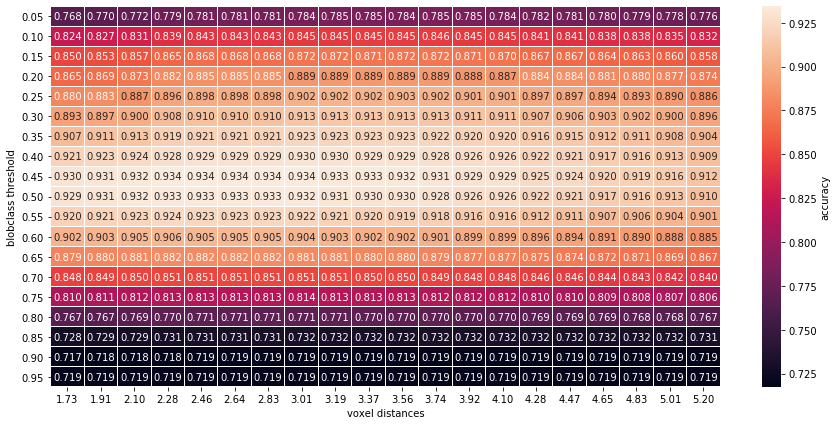

In [50]:
plot_net_stats_heatmap(results_df_full_fast, figsize = (15, 7), xlabel = 'voxel distances', ylabel = 'blobclass threshold')